In [2]:
# IMPORTS
import torch
from torch import nn
import torch.optim as optim
from torch.optim import lr_scheduler
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

from tokenizers import  Tokenizer
from tokenizers.models import BPE
from tokenizers.trainers import BpeTrainer
from tokenizers.pre_tokenizers import Punctuation, Whitespace
from tokenizers.normalizers import Lowercase
from tokenizers import pre_tokenizers, normalizers
from tokenizers.processors import BertProcessing

import glob
from os.path import exists
import os

import pickle5 as pickle
import wandb

import pandas as pd
import numpy as np

In [3]:
def save_checkpoint(save_path, model, optimizer, valid_loss):

    if save_path == None:
        return
    
    state_dict = {'model_state_dict': model.state_dict(),
                  'optimizer_state_dict': optimizer.state_dict(),
                  'valid_loss': valid_loss}
    
    torch.save(state_dict, save_path)
    print(f'Model saved to ==> {save_path}')


def load_checkpoint(load_path, model, optimizer, device):

    if load_path==None:
        return
    
    state_dict = torch.load(load_path, map_location=device)
    print(f'Model loaded from <== {load_path}')
    
    model.load_state_dict(state_dict['model_state_dict'])
    optimizer.load_state_dict(state_dict['optimizer_state_dict'])
    
    return state_dict['valid_loss']

In [3]:
class ContrastiveLoss(nn.Module):
    def __init__(self, batch_size, device, temperature=0.5):
        super().__init__()
        self.batch_size = batch_size
        self.device = device
        self.register_buffer("temperature", torch.tensor(temperature))
        self.register_buffer("negatives_mask", (~torch.eye(batch_size * 2, batch_size * 2, dtype=bool)).float())
            
    def forward(self, emb_i, emb_j):
        """
        emb_i and emb_j are batches of embeddings, where corresponding indices are pairs
        z_i, z_j as per SimCLR paper
        """
        z_i = F.normalize(emb_i, dim=1)
        z_j = F.normalize(emb_j, dim=1)

        representations = torch.cat([z_i, z_j], dim=0)
        
        similarity_matrix = F.cosine_similarity(representations.unsqueeze(1), representations.unsqueeze(0), dim=2)
        
        sim_ij = torch.diag(similarity_matrix, self.batch_size)
        sim_ji = torch.diag(similarity_matrix, -self.batch_size)
        positives = torch.cat([sim_ij, sim_ji], dim=0)
        
        nominator = torch.exp(positives / self.temperature)
        denominator = self.negatives_mask.to(self.device) * torch.exp(similarity_matrix / self.temperature)
    
        loss_partial = -torch.log(nominator / torch.sum(denominator, dim=1))
        loss = torch.sum(loss_partial) / (2 * self.batch_size)
        return loss

Dataset for three stages

## Pretraining

In [205]:
def train(model,
        optimizer,
        train_loader,
        valid_loader,
        batch_size,
        file_path,
        embedding_size,
        device='cpu',
        num_epochs=2,
        epoch_patience=10,
        best_valid_loss = float("Inf"),
        dimension=128,
        save_model=True,
        temperature=0.1):

    
    train_running_loss = 0.0
    valid_running_loss = 0.0
    train_loss_list = []
    valid_loss_list = []
    total_train_steps = len(train_loader)
    total_val_steps = len(valid_loader)
    stop_training = 0


    for epoch in range(num_epochs):
            model.train()
            train_step = 1
            print(f'Epoch {epoch+1}/{num_epochs} training..')
            criterion = ContrastiveLoss(batch_size=batch_size, device=device, temperature=temperature)

            for  tensor_demo, tensor_diags, tensor_vitals, tensor_labs, tensor_meds, idx in train_loader:
                if train_step % 100==0:
                    print(f'Step {train_step}/{total_train_steps}')
                # print(f'Step {train_step}/{total_train_steps}')

                vector_X, projectionX, vector_Y, projectionY = model(tensor_demo.to(device), tensor_diags.to(device),\
                                                                    tensor_meds.to(device), tensor_vitals.to(device),\
                                                                    tensor_labs.to(device))
                                        
                if train_step >= total_train_steps:
                        new_batch_size = projectionX.size()[0]
                        criterion = ContrastiveLoss(batch_size=new_batch_size, device=device, temperature=temperature)
                
                loss = criterion(projectionX.type(torch.float32), projectionY.type(torch.float32))
                #   print(loss.item())
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()

                train_running_loss += loss.item()
                train_step += 1

                wandb.log({'step_train_loss': loss.item(), 'global_step': train_step})

            epoch_average_train_loss = train_running_loss / len(train_loader)  

            model.eval()
            val_step = 1
            print(f"Validation started..")
            criterion = ContrastiveLoss(batch_size=batch_size, device=device, temperature=temperature)
            with torch.no_grad():
                for tensor_demo, tensor_diags, tensor_vitals, tensor_labs, tensor_meds, idx in valid_loader:
                        vector_X, projectionX, vector_Y, projectionY = model(tensor_demo.to(device), tensor_diags.to(device),\
                                                                    tensor_meds.to(device), tensor_vitals.to(device),\
                                                                    tensor_labs.to(device))

                        if val_step >= total_val_steps:
                            new_batch_size = projectionX.size()[0]
                            criterion = ContrastiveLoss(batch_size=new_batch_size, device=device, temperature=temperature)
                                            
                        loss = criterion(projectionX.type(torch.float32), projectionY.type(torch.float32))

                        valid_running_loss += loss.item()
                        val_step += 1
                        

            epoch_average_val_loss = valid_running_loss / len(valid_loader)

            train_running_loss = 0.0
            valid_running_loss = 0.0

            print(f'Train loss {epoch_average_train_loss}, Validation loss {epoch_average_val_loss}')

            wandb.log({'epoch_average_train_loss':epoch_average_train_loss, 'epoch_average_val_loss':epoch_average_val_loss, 'epoch':epoch+1})
            
            # checkpoint
            if best_valid_loss > epoch_average_val_loss and save_model:
                print(f'Validation loss decreased {best_valid_loss}==>{epoch_average_val_loss}')
                best_valid_loss = epoch_average_val_loss
                save_checkpoint(file_path + '/model.pt', model, optimizer, best_valid_loss)
                wandb.save(file_path + '/model.pt')
                stop_training = 0
            else:
                stop_training +=1
            
            if stop_training == epoch_patience:
                break

    print('Finished training!')

In [109]:
new_fixed_model = True
fixed_model_with_diags = False
cont_model = False

def main(project_name, num_epochs, pred_window, max_day, PRETRAINED_PATH=None, drop=0.1, \
    temperature=0.5, embedding_size=200, min_frequency=1, BATCH_SIZE=16, small_dataset=True, \
        LR=0.000005, save_model=False, use_gpu=True, saving_folder_name=None, wandb_mode = 'online', \
            run_id=None):
    
    if use_gpu:
        device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    else:
        device='cpu'
    print('device: ', device)
    
    #paths
    CURR_PATH = os.getcwd()
    PKL_PATH = CURR_PATH+'/pickles/'
    DF_PATH = '/home/svetlana.maslenkova/LSTM/dataframes/'
    TXT_DIR_TRAIN = CURR_PATH + '/txt_files/train'
    destination_folder = '/l/users/svetlana.maslenkova/models' + '/pretraining/fc1_fixed/'


    # Training the tokenizer
    if exists(CURR_PATH + '/tokenizer.json'):
        tokenizer = Tokenizer.from_file(CURR_PATH + '/tokenizer.json')
        print(f'Tokenizer is loaded from ==> {CURR_PATH}/tokenizer.json. Vocab size is {tokenizer.get_vocab_size()}')
    else:
        print('Training tokenizer...')
        os.environ["TOKENIZERS_PARALLELISM"] = "true"
        tokenizer = Tokenizer(BPE(unk_token="UNK"))
        tokenizer.normalizer = normalizers.Sequence([Lowercase()])
        # tokenizer.pre_tokenizer = pre_tokenizers.Sequence([Whitespace(), Digits(individual_digits=False), Punctuation( behavior = 'removed')])
        tokenizer.pre_tokenizer = pre_tokenizers.Sequence([Whitespace(), Punctuation(behavior = 'isolated')])

        trainer = BpeTrainer(special_tokens=["<s>", "</s>", "PAD", "UNK", "$"], min_frequency=10)

        files = glob.glob('/home/svetlana.maslenkova/LSTM/aki_prediction/txt_files/train'+'/*')
        tokenizer.train(files, trainer)
        tokenizer.post_processor = BertProcessing(
                ("</s>", tokenizer.token_to_id("</s>")),
                ("<s>", tokenizer.token_to_id("<s>")), 
                )
        os.environ["TOKENIZERS_PARALLELISM"] = "false"

    # variables for classes
    # max_length = {'demographics':5, 'lab_tests':400, 'vitals':200, 'medications':255}
    max_length = {'demographics':5+2, 'diagnoses':35+2, 'lab_tests':300+2, 'vitals':31+2, 'medications':256+2}
    vocab_size = tokenizer.get_vocab_size()
    print(f'Vocab size: {vocab_size}')

    with open(DF_PATH + 'pid_train_df_pretraining.pkl', 'rb') as f:
        pid_train_df = pickle.load(f)

    with open(DF_PATH + 'pid_val_df_pretraining.pkl', 'rb') as f:
        pid_val_df = pickle.load(f)

    if small_dataset: frac=0.0001 
    else: frac=1
    
    pid_train_df_small = pid_train_df.sample(frac=frac)
    pid_val_df_small = pid_val_df.sample(frac=frac)

    if fixed_model_with_diags:
        train_dataset = MyDataset(pid_train_df.sample(frac=frac), tokenizer=tokenizer, max_length_day=400)
        train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)

        val_dataset = MyDataset(pid_val_df.sample(frac=frac), tokenizer=tokenizer, max_length_day=400)
        val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=True)

    elif cont_model:
        train_dataset = MyDataset(pid_train_df_small, tokenizer=tokenizer, max_length=max_length)
        train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)

        val_dataset = MyDataset(pid_val_df_small, tokenizer=tokenizer, max_length=max_length)
        val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=True)

    elif new_fixed_model:
        train_dataset = MyDataset(pid_train_df.sample(frac=frac), tokenizer=tokenizer, max_length=max_length)
        train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)

        val_dataset = MyDataset(pid_val_df.sample(frac=frac), tokenizer=tokenizer, max_length=max_length)
        val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=True)

    print('DATA SHAPES: ')
    print('train data shape: ', len(train_loader)*BATCH_SIZE)
    print('val data shape: ', len(val_loader)*BATCH_SIZE)

    if fixed_model_with_diags:
        model = EHR_PRETRAINING(max_length=400, vocab_size=vocab_size, device=device).to(device)
    elif cont_model:
        model = EHR_model(embedding_size=embedding_size, vocab_size=vocab_size, max_length=max_length, pred_window=pred_window, max_day=max_day, drop=0.1).to(device)
    elif new_fixed_model:
        model = EHR_PRETRAINING(max_length=max_length, vocab_size=vocab_size, device=device, pred_window=2, observing_window=3,  H=128, embedding_size=200, drop=0.6)
    
    optimizer = optim.Adam(model.parameters(), lr=LR)
    # Decay LR by a factor of 0.1 every 7 epochs
    exp_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

    if PRETRAINED_PATH is not None:
        load_checkpoint(PRETRAINED_PATH, model, optimizer, device=device)
    
    train_params = {'model':model,
                    'optimizer':optimizer,
                    'train_loader':train_loader,
                    'valid_loader':val_loader,
                    'batch_size':BATCH_SIZE,
                    'embedding_size':embedding_size,
                    'file_path':destination_folder,
                    'num_epochs':num_epochs,
                    'device':device,
                    'save_model':save_model,
                    'temperature':temperature
    }

    num_samples = (len(train_loader)+len(val_loader))*BATCH_SIZE // 1000

    if saving_folder_name is None:
        saving_folder_name = 'CL_WHOLE_FX_ND_' + '_bs' + str(BATCH_SIZE) +'_' + str(num_samples) + 'k' + '_lr'+ str(LR) + '_Adam' + '_temp' + str(temperature) + '_drop' + str(drop)
    file_path = destination_folder + saving_folder_name
    train_params['file_path'] = file_path

    print(f'\n\nMODEL PATH: {file_path}')
    if not os.path.exists(file_path):
        os.makedirs(file_path)
        
    run_name = saving_folder_name
    print('Run name: ', run_name)
    args = {'optimizer':'Adam', 'LR':LR, 'min_frequency':min_frequency, 'dropout':drop, \
        'vocab_size':vocab_size, 'embedding_size':embedding_size, 'pretrained':'FC1', \
            'temperature':temperature, 'batch_size':BATCH_SIZE,  'experiment':'FX_DIAGS_ND', \
                'pretrained':'whole'}

    if run_id is None:    
        run_id = wandb.util.generate_id()  
        resume = 'allow' 
    else:
        resume = 'must'

    print('Run id is: ', run_id)
    wandb.init(project=project_name, name=run_name, mode=wandb_mode, config=args, id=run_id, resume=resume)
    train(**train_params)
    wandb.finish()

In [112]:
main(project_name='test', num_epochs=1, pred_window=None, max_day=None, PRETRAINED_PATH=None, drop=0.1, \
    temperature=0.1, embedding_size=200, min_frequency=5, BATCH_SIZE=16, small_dataset=True, \
        LR=0.00001, save_model=True, use_gpu=False, saving_folder_name='test', wandb_mode = 'disabled', \
            run_id=None)

device:  cpu
Training tokenizer...



Vocab size: 22569
DATA SHAPES: 
train data shape:  48
val data shape:  16


MODEL PATH: /l/users/svetlana.maslenkova/models/pretraining/fc1_fixed/test
Run name:  test
Run id is:  14bnw4hp
Epoch 1/1 training..


RuntimeError: shape '[16, 9472]' is invalid for input of size 143360

In [4]:
#paths
CURR_PATH = os.getcwd()
PKL_PATH = CURR_PATH+'/pickles/'
DF_PATH = '/home/svetlana.maslenkova/LSTM/dataframes/'
TXT_DIR_TRAIN = CURR_PATH + '/txt_files/train'
destination_folder = '/l/users/svetlana.maslenkova/models' + '/pretraining/fc1_fixed/'

# Training the tokenizer
if exists(CURR_PATH + '/tokenizer.json'):
    tokenizer = Tokenizer.from_file(CURR_PATH + '/tokenizer.json')
    print(f'Tokenizer is loaded from ==> {CURR_PATH}/tokenizer.json. Vocab size is {tokenizer.get_vocab_size()}')
else:
    print('Training tokenizer...')
    os.environ["TOKENIZERS_PARALLELISM"] = "true"
    tokenizer = Tokenizer(BPE(unk_token="UNK"))
    tokenizer.normalizer = normalizers.Sequence([Lowercase()])
    # tokenizer.pre_tokenizer = pre_tokenizers.Sequence([Whitespace(), Digits(individual_digits=False), Punctuation( behavior = 'removed')])
    tokenizer.pre_tokenizer = pre_tokenizers.Sequence([Whitespace(), Punctuation(behavior = 'isolated')])

    trainer = BpeTrainer(special_tokens=["<s>", "</s>", "PAD", "UNK", "$"], min_frequency=10)

    files = glob.glob('/home/svetlana.maslenkova/LSTM/aki_prediction/txt_files/train'+'/*')
    tokenizer.train(files, trainer)
    tokenizer.post_processor = BertProcessing(
            ("</s>", tokenizer.token_to_id("</s>")),
            ("<s>", tokenizer.token_to_id("<s>")), 
            )
    os.environ["TOKENIZERS_PARALLELISM"] = "false"
    tokenizer.save(CURR_PATH + '/tokenizer.json')


Tokenizer is loaded from ==> /home/svetlanamaslenkova/Documents/AKI_deep/LSTM/aki_prediction/pretraining/tokenizer.json. Vocab size is 22569


In [5]:
device='cpu'
max_length = {'demographics':5+2, 'diagnoses':35+2, 'lab_tests':300+2, 'vitals':31+2, 'medications':256+2}
vocab_size = tokenizer.get_vocab_size()
print(f'Vocab size: {vocab_size}')

small_dataset = True
BATCH_SIZE = 128
LR = 0.00001

Vocab size: 22569


In [10]:
DF_PATH = '/home/svetlanamaslenkova/Documents/AKI_deep/LSTM/dataframes/'

with open(DF_PATH + 'pid_train_df_pretraining.pkl', 'rb') as f:
    pid_train_df = pickle.load(f)

with open(DF_PATH + 'pid_val_df_pretraining.pkl', 'rb') as f:
    pid_val_df = pickle.load(f)

if small_dataset: frac=0.0001 
else: frac=1

# pid_train_df_small = pid_train_df.sample(frac=frac)
# pid_val_df_small = pid_val_df.sample(frac=frac)

In [284]:
if fixed_model_with_diags:
    train_dataset = MyDataset(pid_train_df.sample(frac=frac), tokenizer=tokenizer, max_length_day=400)
    train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)

    val_dataset = MyDataset(pid_val_df.sample(frac=frac), tokenizer=tokenizer, max_length_day=400)
    val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=True)

elif cont_model:
    train_dataset = MyDataset(pid_train_df_small, tokenizer=tokenizer, max_length=max_length)
    train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)

    val_dataset = MyDataset(pid_val_df_small, tokenizer=tokenizer, max_length=max_length)
    val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=True)

elif new_fixed_model:
    print(f'new_fixed_model')
    train_dataset = MyDataset(pid_train_df.sample(frac=frac), tokenizer=tokenizer, max_length=max_length)
    train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)

    val_dataset = MyDataset(pid_val_df.sample(frac=frac), tokenizer=tokenizer, max_length=max_length)
    val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=True)


if fixed_model_with_diags:
    model = EHR_PRETRAINING(max_length=400, vocab_size=vocab_size, device=device).to(device)
elif cont_model:
    model = EHR_model(embedding_size=embedding_size, vocab_size=vocab_size, max_length=max_length, pred_window=pred_window, max_day=max_day, drop=0.1).to(device)
elif new_fixed_model:
    pretrained_model = EHR_PRETRAINING(max_length=max_length, vocab_size=vocab_size, device=device, pred_window=2, observing_window=3,  H=128, embedding_size=200, drop=0.6)


new_fixed_model


In [193]:
embedding_size = 200
num_epochs = 1
save_model = False
temperature = 0.1

In [203]:
optimizer = optim.Adam(model.parameters(), lr=LR)

train_params = {'model':model,
                'optimizer':optimizer,
                'train_loader':train_loader,
                'valid_loader':val_loader,
                'batch_size':BATCH_SIZE,
                'embedding_size':embedding_size,
                'file_path':destination_folder,
                'num_epochs':num_epochs,
                'device':device,
                'save_model':save_model,
                'temperature':temperature
}

In [206]:
train(**train_params)

Epoch 1/1 training..
out_emb_diags:  torch.Size([36, 37, 200])
out_emb_demo:  torch.Size([36, 7, 200])
out_lstm_diags:  torch.Size([36, 37, 256])
out_lstm_demo:  torch.Size([36, 7, 256])
out_lstm_diags_reshaped torch.Size([36, 9472])
out_lstm_demo_reshaped torch.Size([36, 1792])
full_output torch.Size([36, 11264])
out_med_emb torch.Size([36, 258, 200])
out_vitals_emb torch.Size([36, 33, 200])
out_labs_emb torch.Size([36, 302, 200])
output_lstm_med torch.Size([36, 2048])
output_lstm_vitals torch.Size([36, 2048])
output_lstm_labs torch.Size([36, 2048])
--------------
out_med_emb torch.Size([36, 258, 200])
out_vitals_emb torch.Size([36, 33, 200])
out_labs_emb torch.Size([36, 302, 200])
output_lstm_med torch.Size([36, 2048])
output_lstm_vitals torch.Size([36, 2048])
output_lstm_labs torch.Size([36, 2048])
--------------
out_med_emb torch.Size([36, 258, 200])
out_vitals_emb torch.Size([36, 33, 200])
out_labs_emb torch.Size([36, 302, 200])
output_lstm_med torch.Size([36, 2048])
output_lstm_v

In [210]:
tensor_demo, tensor_diags, tensor_vitals, tensor_labs, tensor_meds, idx = next(iter(train_loader))

vector_X, projectionX, vector_Y, projectionY = model(tensor_demo.to(device), tensor_diags.to(device),\
                                                    tensor_meds.to(device), tensor_vitals.to(device),\
                                                    tensor_labs.to(device))

out_emb_diags:  torch.Size([36, 37, 200])
out_emb_demo:  torch.Size([36, 7, 200])
out_lstm_diags:  torch.Size([36, 37, 256])
out_lstm_demo:  torch.Size([36, 7, 256])
out_lstm_diags_reshaped torch.Size([36, 9472])
out_lstm_demo_reshaped torch.Size([36, 1792])
full_output torch.Size([36, 11264])
--------------
out_med_emb torch.Size([36, 258, 200])
out_vitals_emb torch.Size([36, 33, 200])
out_labs_emb torch.Size([36, 302, 200])

lstm_day(out_med_emb)  torch.Size([36, 258, 256]) ==> [36, 66048]
output_lstm_med torch.Size([36, 2048])

lstm_day(out_vitals_emb)  torch.Size([36, 33, 256]) ==> [36, 8448]
output_lstm_vitals torch.Size([36, 2048])

lstm_day(out_labs_emb)  torch.Size([36, 302, 256]) ==> [36, 77312]
output_lstm_labs torch.Size([36, 2048])
--------------
out_med_emb torch.Size([36, 258, 200])
out_vitals_emb torch.Size([36, 33, 200])
out_labs_emb torch.Size([36, 302, 200])

lstm_day(out_med_emb)  torch.Size([36, 258, 256]) ==> [36, 66048]
output_lstm_med torch.Size([36, 2048])

lstm

In [209]:
max_length = {'demographics':5+2, 'diagnoses':35+2, 'lab_tests':300+2, 'vitals':31+2, 'medications':256+2}
tensor_demo, tensor_diags, tensor_vitals, tensor_labs, tensor_meds, idx = next(iter(train_loader))
model = EHR_PRETRAINING(max_length=max_length, vocab_size=vocab_size, device=device, pred_window=2, observing_window=3,  H=128, embedding_size=200, drop=0.6)

In [183]:
tensor_diags.size()

torch.Size([16, 35])

In [6]:
#paths
CURR_PATH = os.getcwd()
PKL_PATH = CURR_PATH+'/pickles/'
DF_PATH = CURR_PATH +'/dataframes/'
TXT_DIR_TRAIN = CURR_PATH + '/txt_files/train'
destination_folder = '/l/users/svetlana.maslenkova/models' + '/pretraining/fc1_fixed/'

In [153]:
# tokenizer = Tokenizer.from_file('/home/svetlana.maslenkova/LSTM/aki_prediction/tokenizer.json')
# print(f' Vocab size is {tokenizer.get_vocab_size()}')

with open('/home/svetlana.maslenkova/LSTM/dataframes/pid_train_df_pretraining.pkl', 'rb') as f:
    pid_train_df = pickle.load(f)


In [8]:
pid_train_df.head(1)

,subject_id,hadm_id,demographics_in_visit,lab_tests_in_visit,medications_in_visit,vitals_in_visit,days_in_visit,previous_diagnoses,days
0,10467237,20000019,"[hispanic latino f 76 , hispanic latino f 76 ...",[hematology blood hematocrit 26.5 %; hematol...,[pneumococcal 23-valent polysaccharide vaccine...,[temp 98.0 heartrate 65.0 resprate 16.0 ...,[hispanic latino f 76 $temp 98.0 heartrate ...,,"[0, 1, 2]"


In [ ]:
i = 0
LIST_HADMS = []
list_diags = []
# for _, row in pid_val_df.iterrows():
#     # try:
#     #     list_diags.append(row.previous_diagnoses[0].replace('PAD ', '').replace('PAD', ''))
#     #     LIST_HADMS.append(row.hadm_id)
#     # except:
#     #     print(row.previous_diagnoses[0])
#     #     print(np.isnan(row.previous_diagnoses[0]))
#     #     break
#     try:
#         if isinstance(row.previous_diagnoses[0], float):
#             list_diags.append('')      
#         else:
#             list_diags.append(row.previous_diagnoses[0].replace('PAD ', '').replace('PAD', ''))  
#         LIST_HADMS.append(row.hadm_id) 
#     except:
#         print(row.previous_diagnoses[0])
#         print(type(row.previous_diagnoses[0]))
#         raise
#         break

#     i+=1
#     # if i>0:break

pid_train_df['previous_diags'] = [val.replace('PAD ', '').replace('PAD', '') if not isinstance(val, float) else '' for val in pid_train_df['previous_diags']]

# Tokenizer

In [14]:
#paths
diagnoses = 'icd'
min_frequency = 10
CURR_PATH = os.getcwd()
PKL_PATH = CURR_PATH+'/pickles/'
DF_PATH = CURR_PATH +'/dataframes/'
destination_folder = '/l/users/svetlana.maslenkova/models' + '/pretraining/three_stages/'
# destination_folder = '/home/svetlanamaslenkova/Documents/AKI_deep/training/'

if diagnoses=='icd':
        TOKENIZER_PATH = CURR_PATH  + '/tokenizer.json'
        TXT_DIR_TRAIN = CURR_PATH + '/txt_files/train'
elif diagnoses=='titles':
        TOKENIZER_PATH = CURR_PATH + '/tokenizer_titles.json'
        TXT_DIR_TRAIN = CURR_PATH + '/txt_files/titles_diags'

# Training the tokenizer
if exists(TOKENIZER_PATH):
        tokenizer = Tokenizer.from_file(TOKENIZER_PATH)
        print(f'Tokenizer is loaded from ==> {TOKENIZER_PATH}/tokenizer.json. Vocab size is {tokenizer.get_vocab_size()}')
else:
        print('Training tokenizer...')
        os.environ["TOKENIZERS_PARALLELISM"] = "true"
        tokenizer = Tokenizer(BPE(unk_token="UNK"))
        tokenizer.normalizer = normalizers.Sequence([Lowercase()])
        # tokenizer.pre_tokenizer = pre_tokenizers.Sequence([Whitespace(), Digits(individual_digits=False), Punctuation( behavior = 'removed')])
        tokenizer.pre_tokenizer = pre_tokenizers.Sequence([Whitespace(), Punctuation(behavior = 'isolated')])

        trainer = BpeTrainer(special_tokens=["<s>", "</s>", "PAD", "UNK", "$"], min_frequency=min_frequency)

        files = glob.glob(TXT_DIR_TRAIN+'/*')
        tokenizer.train(files, trainer)
        tokenizer.post_processor = BertProcessing(
                ("</s>", tokenizer.token_to_id("</s>")),
                ("<s>", tokenizer.token_to_id("<s>")), 
                )
        os.environ["TOKENIZERS_PARALLELISM"] = "false"
        print(f'Vocab size is {tokenizer.get_vocab_size()}')

Tokenizer is loaded from ==> /home/svetlanamaslenkova/Documents/AKI_deep/LSTM/aki_prediction/pretraining/tokenizer.json/tokenizer.json. Vocab size is 22569


In [15]:
vocab_size = tokenizer.get_vocab_size()
print(vocab_size)
device='cpu'
frac=1
BATCH_SIZE=1024
LR=0.00001

22569


In [20]:
train_dataset = MyDataset(pid_train_df.sample(frac=frac), tokenizer=tokenizer)
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)

In [21]:
model = EHR_PRETRAINING(max_length=400, vocab_size=vocab_size, device=device).to(device)
optimizer = optim.Adam(model.parameters(), lr=LR)

NameError: name 'EHR_PRETRAINING' is not defined

Tokenization

In [160]:
tensor_demo, tensor_diags, tensor_vitals, tensor_labs, tensor_meds, idx = next(iter(train_loader))
print(idx)
# for idx, (tensor_demo, tensor_diags, tensor_vitals, tensor_labs, tensor_meds, idx) in enumerate(train_dataset):
#     print(idx)

tensor([25608940, 26676014, 25229043, 22517940, 20539214, 28675100, 21815284,
        22431587, 24259871, 29837158, 23507274, 27676611, 21343164, 20376368,
        28143288, 27172224])


In [13]:
i = 1
tokenizer.decode(tensor_vitals[i][0].cpu().detach().numpy())

'temp 98 . 8 heartrate 96 . 0 resprate 18 . 0 o2sat 97 . 0 sbp 100 . 0 dbp 59 . 0 rhythm pain 8'

In [21]:
a = np.array([0,0,0,0,1,0])
idx = np.where(a==1)[0][0]
a[idx]

1

## Plot lengths

In [34]:
lens_meds = []
tokenizer.enable_truncation(500)
for tensor_demo, tensor_diags, tensor_vitals, tensor_labs, tensor_meds, idx in train_loader:
    for sample in tensor_meds.cpu().detach():
        for day in sample:
            # print(day)
            idx = np.where(day==1)[0][0]
            # print(len(day[:idx]))
            lens_meds.append(len(day[:idx]))


Text(0, 0.5, 'Num of tensors')

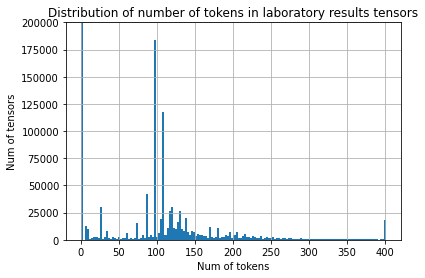

In [40]:
from matplotlib import pyplot as plt
%matplotlib inline

plt.hist(lens, density=False, bins=150)
plt.ylim(0, 200000)
plt.grid()
plt.title('Distribution of number of tokens in laboratory results tensors')
plt.xlabel('Num of tokens')
plt.ylabel('Num of tensors')

256


Text(0, 0.5, 'Num of tensors')

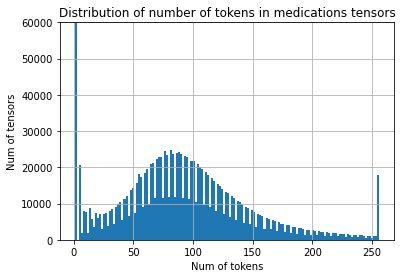

In [39]:
from matplotlib import pyplot as plt
%matplotlib inline
print(np.max(lens_meds))
plt.hist(lens_meds, density=False, bins=150)
plt.ylim(0, 60000)
plt.grid()
plt.title('Distribution of number of tokens in medications tensors')
plt.xlabel('Num of tokens')
plt.ylabel('Num of tensors')

In [812]:
for p in tensor_vitals[i]:
    print(p.cpu().detach().numpy(), "===>", tokenizer.decode(p.cpu().detach().numpy()))

[  0 478 565  17  26 487 960  17  19 489 280  17  19 488 117  17  19 485
 988  17  19 483 326  17  19 475 479   1   2   2   2   2   2   2   2   2
   2   2   2   2   2   2   2   2   2   2   2   2   2   2   2   2   2   2
   2   2   2   2   2   2   2   2   2   2   2   2   2   2   2   2   2   2
   2   2   2   2   2   2   2   2   2   2   2   2   2   2   2   2   2   2
   2   2   2   2   2   2   2   2   2   2   2   2   2   2   2   2   2   2
   2   2   2   2   2   2   2   2   2   2   2   2   2   2   2   2   2   2
   2   2   2   2   2   2   2   2   2   2   2   2   2   2   2   2   2   2
   2   2   2   2   2   2   2   2   2   2   2   2   2   2   2   2   2   2
   2   2   2   2   2   2   2   2   2   2   2   2   2   2   2   2   2   2
   2   2   2   2   2   2   2   2   2   2   2   2   2   2   2   2   2   2
   2   2   2   2] ===> temp 97 . 7 heartrate 53 . 0 resprate 18 . 0 o2sat 10 . 0 sbp 129 . 0 dbp 99 . 0 rhythm pain
[0 2 1 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2

In [749]:
day = pid_train_df[pid_train_df.hadm_id==idx[i].item()].previous_diagnoses.values[0]
day

''

In [733]:
output = tokenizer.encode(day)

In [734]:
tokenizer.decode(output.ids)

'de119 db20 de785 di10 dr338'

In [722]:
print(len(output.ids))
print(output.ids)

7
[0, 4277, 849, 3387, 828, 3507, 1]


In [723]:
for id_ in output.ids:
    print(id_, tokenizer.id_to_token(id_))

0 <s>
4277 d42843
849 d2449
3387 d5939
828 d4280
3507 d4239
1 </s>


In [752]:
print(len(tensor_vitals[i].cpu().detach().numpy()))

5


In [753]:
for id_ in tensor_vitals[i].cpu().detach().numpy():
    print(id_, tokenizer.id_to_token(id_))

TypeError: only integer scalar arrays can be converted to a scalar index

In [481]:
tokenizer.id_to_token(24)

'7'

# Fine-tuning

## Utils

In [9]:
# Save and Load Functions
def save_checkpoint(save_path, model, optimizer, valid_loss):

    if save_path == None:
        return
    
    state_dict = {'model_state_dict': model.state_dict(),
                  'optimizer_state_dict': optimizer.state_dict(),
                  'valid_loss': valid_loss}
    
    torch.save(state_dict, save_path)
    print(f'Model saved to ==> {save_path}')


def load_checkpoint(load_path, model, optimizer, device):

    if load_path==None:
        return
    
    state_dict = torch.load(load_path, map_location=device)
    print(f'Model loaded from <== {load_path}')
    
    model.load_state_dict(state_dict['model_state_dict'])
    optimizer.load_state_dict(state_dict['optimizer_state_dict'])
    
    return state_dict['valid_loss']


def save_metrics(save_path, train_loss_list, valid_loss_list, global_steps_list):

    if save_path == None:
        return
    
    state_dict = {'train_loss_list': train_loss_list,
                  'valid_loss_list': valid_loss_list,
                  'global_steps_list': global_steps_list}
    
    torch.save(state_dict, save_path)
    print(f'Model saved to ==> {save_path}')


def load_metrics(load_path):

    if load_path==None:
        return
    
    state_dict = torch.load(load_path, map_location=device)
    print(f'Model loaded from <== {load_path}')
    
    return state_dict['train_loss_list'], state_dict['valid_loss_list'], state_dict['global_steps_list']

def calculate_class_weights(data_loader):
    labels = np.array([])
    for tensor_day, tensor_diags, tensor_labels, idx in data_loader:
        labels = np.concatenate([labels, tensor_labels], axis=0) if labels.size else tensor_labels
    n_pos = np.sum(labels==1, axis=0)
    n_neg = np.sum(labels==0, axis=0)
    pos_weight = np.round(n_neg / n_pos, 2)
    
    return pos_weight

def get_lr(optimizer):
    for param_group in optimizer.param_groups:
        return param_group['lr']

## Models

In [8]:
class EHR_FINETUNING(nn.Module):
    def __init__(self, pretrained_model, max_length, vocab_size, device, pred_window=2, observing_window=3,  H=128, embedding_size=200, drop=0.6):
        super(EHR_FINETUNING, self).__init__()

        self.observing_window = observing_window
        self.pred_window = pred_window
        self.H = H
        self.max_length_demo = max_length['demographics']
        self.max_length_diags = max_length['diagnoses']
        self.max_length_meds = max_length['medications']
        self.max_length_vitals = max_length['vitals']
        self.max_length_lab = max_length['lab_tests']
        self.embedding_size = embedding_size
        self.vocab_size = vocab_size
        self.device = device
        self.drop = drop

        # self.embedding = pretrained_model
        self.embedding = pretrained_model.embedding

        self.lstm_day = pretrained_model.lstm_day

        self.fc_med = pretrained_model.fc_med
        self.fc_vitals = pretrained_model.fc_vitals
        self.fc_lab = pretrained_model.fc_lab

        self.fc_adm = pretrained_model.fc_adm

        self.lstm_adm = pretrained_model.lstm_adm

        self.drop = nn.Dropout(p=drop)
        self.inner_drop = nn.Dropout(p=0.5)

        self.fc_2 = nn.Linear(pretrained_model.lstm_adm.hidden_size, 2)

    def forward(self, tensor_demo, tensor_diags, tensor_med, tensor_vitals, tensor_labs):

        batch_size = tensor_demo.size()[0]

        # embeddings
        out_emb_diags = self.embedding(tensor_diags.squeeze(1)) # [16, 37, 200]
        out_emb_demo =  self.embedding(tensor_demo.squeeze(1))  # [16, 7, 200]
        # print(f'out_emb_diags: ', out_emb_diags.size())
        # print(f'out_emb_demo: ', out_emb_demo.size())
        # lstm for demographic and diagnoses
        out_lstm_diags, _ = self.lstm_day(out_emb_diags)    # [16, 37, 256]
        out_lstm_demo, _ = self.lstm_day(out_emb_demo)      # [16, 7, 256]
        # print(f'out_lstm_diags: ', out_lstm_diags.size())
        # print(f'out_lstm_demo: ', out_lstm_demo.size())
        # reshape and concat demographics and diags
        out_lstm_diags_reshaped = out_lstm_diags.reshape(batch_size, self.max_length_diags * 2 * self.H)
        out_lstm_demo_reshaped = out_lstm_demo.reshape(batch_size, self.max_length_demo * 2 * self.H)
        # print(f'out_lstm_diags_reshaped', out_lstm_diags_reshaped.size())
        # print(f'out_lstm_demo_reshaped', out_lstm_demo_reshaped.size())
        full_output = torch.cat([out_lstm_demo_reshaped, out_lstm_diags_reshaped], dim=1)   # [16, 11264]
        # print(f'full_output', full_output.size())

        for d in range(self.observing_window):
            # print('--------------')  
            # embedding layer applied to all tensors 
            out_med_emb = self.embedding(tensor_med[:, d, :].squeeze(1))
            out_vitals_emb = self.embedding(tensor_vitals[:, d, :].squeeze(1))
            out_labs_emb = self.embedding(tensor_labs[:, d, :].squeeze(1))
            # print('out_med_emb', out_med_emb.size())
            # print('out_vitals_emb', out_vitals_emb.size())
            # print('out_labs_emb', out_labs_emb.size())

            # lstm layer applied to embedded tensors
            temp = self.lstm_day(out_med_emb)[0]
            # print(f'\nlstm_day(out_med_emb)  {temp.size()} ==> [{batch_size}, {self.max_length_meds * 2 * self.H}]')
            temp = temp.reshape(batch_size, self.max_length_meds * 2 * self.H)
            output_lstm_med = self.inner_drop(self.fc_med(temp))
            # print(f'output_lstm_med {output_lstm_med.size()}')
            output_lstm_med = self.inner_drop(self.fc_med(\
                                                self.lstm_day(out_med_emb)[0]\
                                                    .reshape(batch_size, self.max_length_meds * 2 * self.H)))

            output_lstm_vitals = self.inner_drop(self.fc_vitals(\
                                                self.lstm_day(out_vitals_emb)[0]\
                                                    .reshape(batch_size, self.max_length_vitals * 2 * self.H)))


            output_lstm_labs = self.inner_drop(self.fc_lab(\
                                                self.lstm_day(out_labs_emb)[0]\
                                                    .reshape(batch_size, self.max_length_lab * 2 * self.H)))
                         
            # concatenate for all * days
            full_output = torch.cat((full_output, \
                                        output_lstm_med,\
                                            output_lstm_vitals,\
                                                output_lstm_labs), dim=1) # 

        # print('--------------')  
        # print('full_output size: ', full_output.size(), '\n')
        output = self.fc_adm(full_output)
        # print('fc_adm: ', output.size(), '\n')
        output, _ = self.lstm_adm(output)
        # print('lstm_adm: ', output.size(), '\n')
        output = self.drop(output)
        output = self.fc_2(output)
        # print('output after fc_2', output.size())
        output = torch.squeeze(output, 1)

        return output

## Dataset

In [64]:
class MyDataset(Dataset):

    def __init__(self, df, tokenizer, max_length, pred_window=2, observing_window=3):
        self.df = df
        self.tokenizer = tokenizer
        self.observing_window = observing_window
        self.pred_window = pred_window
        self.max_length = max_length
        # self.max_length_diags = 35

        
    def __len__(self):
        return self.df.shape[0]

    def __getitem__(self, idx):

        return self.make_matrices(idx)
    
    def tokenize(self, text, max_length): 
        
        # max_length = max_length + 2
        self.tokenizer.enable_truncation(max_length=max_length)

        output = self.tokenizer.encode(text)

        # padding and truncation
        if len(output.ids) < max_length:
            len_missing_token = max_length - len(output.ids)
            padding_vec = [self.tokenizer.token_to_id('PAD') for _ in range(len_missing_token)]
            token_output = [*output.ids, *padding_vec]
        elif len(output.ids) > max_length:
            token_output = output.ids[:max_length]
        else:
            token_output = output.ids
        
        return token_output

    def make_matrices(self, idx):
        
        hadm_id = self.df.hadm_id.values[idx]
        diagnoses_info = self.df.previous_diagnoses.values[idx]
        demo_info = self.df.demographics_in_visit.values[idx][0]
        lab_info = self.df.lab_tests_in_visit.values[idx]
        med_info = self.df.medications_in_visit.values[idx]
        vitals_info = self.df.vitals_in_visit.values[idx]
        
        aki_status = self.df.aki_status_in_visit.values[idx]
        days = self.df.days.values[idx]
        # print(idx)

        lab_info_list = []
        med_info_list = []
        vitals_info_list = []
        labels = []
        label_24 = None
        label_48 = None

        for day in range(days[0], days[0] + self.observing_window + self.pred_window):
            # print('day', day)
            if day not in days:
                labels.append(0)
                vitals_info_list.append(self.tokenize('', self.max_length['vitals']))
                lab_info_list.append(self.tokenize('', self.max_length['lab_tests']))
                med_info_list.append(self.tokenize('', self.max_length['medications']))

            else:
                i = days.index(day)

                if np.isfinite(aki_status[i]):                    
                    labels.append(aki_status[i])
                else:
                    labels.append(0)

                # vitals
                if (str(vitals_info[i]) == 'nan') or (vitals_info[i] == np.nan):
                    vitals_info_list.append(self.tokenize('PAD', self.max_length['vitals']))
                else:
                    vitals_info_list.append(self.tokenize(vitals_info[i], self.max_length['vitals']))

                # lab results
                if (str(lab_info[i]) == 'nan') or (lab_info[i] == np.nan):
                    lab_info_list.append(self.tokenize('PAD', self.max_length['lab_tests']))
                else:
                    lab_info_list.append(self.tokenize(lab_info[i], self.max_length['lab_tests']))
                
                # medications
                if (str(med_info[i]) == 'nan') or (med_info[i] == np.nan):
                    med_info_list.append(self.tokenize('PAD', self.max_length['medications']))
                else:
                    med_info_list.append(self.tokenize(med_info[i], self.max_length['medications']))

        # diagnoses
        if (str(diagnoses_info) == 'nan') or (diagnoses_info == np.nan):
            diagnoses_info = self.tokenize('PAD', self.max_length['diagnoses'])
        else:
            diagnoses_info = self.tokenize(diagnoses_info, self.max_length['diagnoses'])

        # demographics
        if (str(demo_info) == 'nan') or (demo_info == np.nan):
            demo_info = self.tokenize('PAD', self.max_length_diags)
        else:
            demo_info = self.tokenize(demo_info, self.max_length['demographics'])

        # get labels for 48h

        # get labels for 24h
        label_24 = labels[-self.pred_window]
        if sum(labels[-self.pred_window:]) > 0:
            label_48 = 1
        else:
            label_48 = 0
        
        #make tensors
        tensor_demo = torch.tensor(demo_info, dtype=torch.int64)
        tensor_diags = torch.tensor(diagnoses_info, dtype=torch.int64)
        tensor_vitals = torch.tensor(vitals_info_list, dtype=torch.int64)
        tensor_labs = torch.tensor(lab_info_list, dtype=torch.int64)
        tensor_meds = torch.tensor(med_info_list, dtype=torch.int64)
        tensor_labels = torch.tensor([label_24, label_48], dtype=torch.float64)
    
        return (tensor_demo, tensor_diags, tensor_vitals, tensor_labs, tensor_meds), hadm_id, tensor_labels

In [28]:
(tensor_demo, tensor_diags, tensor_vitals, tensor_labs, tensor_meds), hadm_id, tensor_labels = next(iter(test_loader))


In [ ]:
tensor_labels

### Dataset check

In [13]:
with open('/home/svetlana.maslenkova/LSTM/dataframes/pid_train_df_finetuning_6days_aki.pkl', 'rb') as f:
    pid_train_df = pickle.load(f)

with open('/home/svetlana.maslenkova/LSTM/dataframes/pid_test_df_finetuning_6days_aki.pkl', 'rb') as f:
    pid_test_df = pickle.load(f)

pid_train_df.head(1)

,subject_id,hadm_id,demographics_in_visit,lab_tests_in_visit,medications_in_visit,vitals_in_visit,days_in_visit,aki_status_in_visit,previous_diagnoses,days
9,16679562,20001395,"[hispanic latino m 73, hispanic latino m 73, h...",[hematology blood hematocrit 51.2 %; hematol...,[influenza vaccine quadrivalent 0.5 ml ; bis...,[temp heartrate 80.0 resprate 16.0 o2sa...,[hispanic latino m 73$temp heartrate 80.0 ...,"[0, 0, 0, 1, 1, 0, 0, 1, 0]",,"[0, 1, 2, 3, 4, 5, 6, 7, 8]"


In [34]:
BATCH_SIZE = 16
frac=1
train_dataset = MyDataset(pid_train_df.sample(frac=frac), tokenizer=tokenizer, max_length=max_length)
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)

test_dataset = MyDataset(pid_test_df.sample(frac=frac), tokenizer=tokenizer, max_length=max_length)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=True)

In [16]:
len(test_dataset)

1755

In [45]:
(tensor_demo, tensor_diags, tensor_vitals, tensor_labs, tensor_meds), hadm_id, tensor_labels = next(iter(train_loader))

In [46]:
for i, v in enumerate(zip(hadm_id.cpu().detach().numpy(), tensor_labels.cpu().detach().numpy())):
    print(i,':', v)

0 : (27380510, array([1., 1.]))
1 : (22132103, array([0., 0.]))
2 : (28381869, array([0., 0.]))
3 : (20853656, array([1., 1.]))
4 : (23652398, array([0., 0.]))
5 : (27668515, array([0., 0.]))
6 : (22928509, array([1., 1.]))
7 : (25748555, array([0., 0.]))
8 : (22169742, array([0., 0.]))
9 : (25569065, array([1., 1.]))
10 : (27512939, array([0., 0.]))
11 : (21164517, array([0., 0.]))
12 : (24279583, array([1., 1.]))
13 : (24635431, array([1., 1.]))
14 : (27483857, array([0., 0.]))
15 : (29877900, array([1., 1.]))


In [48]:
pid_train_df[pid_train_df.hadm_id==20003740]

,subject_id,hadm_id,demographics_in_visit,lab_tests_in_visit,medications_in_visit,vitals_in_visit,days_in_visit,aki_status_in_visit,previous_diagnoses,days
28,10995547,20003740,"[white m 69, white m 69, white m 69, white m 6...",[hematology blood hematocrit 30.9 %; hematol...,[lansoprazole oral disintegrating tab 30 mg ...,"[nan, nan, nan, nan, nan, nan, nan, nan, nan, ...",[white m 69$nan$hematology blood hematocrit 3...,"[0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0]",D51919 D2639 D30000 DV4986 DE915 DV1582 D9351 ...,"[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,..."


In [62]:
mock_dataset = MyDataset(pid_train_df[pid_train_df.hadm_id==20003740], tokenizer=tokenizer, max_length=max_length)

In [63]:
mock_dataset.__getitem__(0)

labels [0, 0, 0, 0, 1]
label_24 0
label48 1


((tensor([  0, 241,  51, 549,   1,   2,   2]),
  tensor([   0, 2636, 1793,  914, 1714, 5619,  745, 9614, 3656, 3040, 5520, 1346,
          2301, 6817, 8868, 3321, 5520,  745, 2207, 1337, 8868, 2636, 2435,    1,
             2,    2,    2,    2,    2,    2,    2,    2,    2,    2,    2,    2,
             2]),
  tensor([[0, 2, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
           2, 2, 2, 2, 2, 2, 2, 2, 2],
          [0, 2, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
           2, 2, 2, 2, 2, 2, 2, 2, 2],
          [0, 2, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
           2, 2, 2, 2, 2, 2, 2, 2, 2],
          [0, 2, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
           2, 2, 2, 2, 2, 2, 2, 2, 2],
          [0, 2, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
           2, 2, 2, 2, 2, 2, 2, 2, 2]]),
  tensor([[  0, 104,  79,  ...,   2,   2,   2],
          [  0, 104,  79,  ..

## Evaluation 

In [26]:
from sklearn.metrics import classification_report, precision_recall_curve, auc, roc_auc_score, accuracy_score, f1_score, recall_score, precision_score, confusion_matrix

def evaluate(model, test_loader, device, threshold=None, log_res=True):
    print('Evaluation..')
    def find_nearest(array, value):
        array = np.asarray(array)
        idx = (np.abs(array - value)).argmin()
        return idx

    device = 'cpu'
    model = model.to(device)
    stacked_labels = torch.tensor([]).to(device)
    stacked_probs = torch.tensor([]).to(device)
    
    model.eval()
    step = 1
    with torch.no_grad():
        for (tensor_demo, tensor_diags, tensor_vitals, tensor_labs, tensor_meds), hadm_id, tensor_labels in test_loader:
            print(f'Step {step}/{len(test_loader)}' )
            labels = tensor_labels.to(device)
            tensor_demo = tensor_demo.to(device)
            tensor_diags = tensor_diags.to(device)
            tensor_vitals = tensor_vitals.to(device)
            tensor_labs = tensor_labs.to(device)
            tensor_meds = tensor_meds.to(device)

            probs = model(tensor_demo.to(device), tensor_diags.to(device), tensor_meds.to(device), \
                                tensor_vitals.to(device), tensor_labs.to(device))
            probs = nn.Sigmoid()(probs)
            # output = (probs > threshold).int()

            # stacking labels and predictions
            stacked_labels = torch.cat([stacked_labels, labels], dim=0, )
            # stacked_preds = torch.cat([stacked_preds, output], dim=0, )
            stacked_probs = torch.cat([stacked_probs, probs], dim=0, )
            step += 1
            
    # transfer to device
    stacked_labels = stacked_labels.cpu().detach().numpy()
    stacked_probs = stacked_probs.cpu().detach().numpy()

    if threshold==None:
        for w in range(stacked_labels.ndim):
            pred_window = (w+1)*24

            precision, recall, thresholds = precision_recall_curve(stacked_labels.T[w], stacked_probs.T[w])
            precision, recall, thresholds = np.round(precision, 2), np.round(recall,2), np.round(thresholds,2)
            
            # convert to f score
            fscore = np.round((2 * precision * recall) / (precision + recall), 2)

            # locate the index of the largest f score
            ix = np.argmax(np.nan_to_num(fscore))
            threshold = np.round(thresholds[ix], 2)
            print('--------------- ', str(pred_window)+'h', '--------------- ')
            print('Best Threshold=%.2f, F-Score=%.2f' % (threshold, fscore[ix]))

            stacked_preds = (stacked_probs.T[w] > threshold).astype(int)
            y_true = stacked_labels.T[0]
            y_pred = stacked_preds

            accuracy = np.round(accuracy_score(y_true, y_pred), 2)
            print(f'Accuracy: {accuracy}')

            f1_score_ = np.round(f1_score(y_true, y_pred, pos_label=1, average='binary', zero_division=0), 2)
            print(f'F1: ', f1_score_)

            recall_score_ = np.round(recall_score(y_true, y_pred, pos_label=1, average='binary', zero_division=0), 2)
            print(f'Sensitivity: ', recall_score_)

            precision_score_ = np.round(precision_score(y_true, y_pred, pos_label=1, average='binary', zero_division=0), 2)
            print(f'Precision: ', precision_score_)

            tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
            specificity =  np.round(tn / (tn + fp), 2)
            print(f'Specificity: ', specificity)

            pr_auc = np.round(auc(recall, precision), 2) 
            print(f'PR AUC: ', pr_auc)

            roc_auc = np.round(roc_auc_score(y_true, y_pred), 2)
            print(f'ROC AUC: ', roc_auc)

            precision_list = [0.2, 0.25, 0.33, 0.4, 0.5, 0.6, 0.75]
            for p in precision_list:
                idx = find_nearest(precision, p)
                sensitivity = recall[idx]
                print(f'Precision {np.round(precision[idx]*100, 1)}% , Sensitivity {sensitivity} ')

            print(f'Confusion matrix:\n', confusion_matrix(y_true, y_pred))


            if log_res:
                wandb.log({'test_accuracy'+str(pred_window) :accuracy, 'test_f1_score'+str(pred_window):f1_score_, \
                            'test_recall_score'+str(pred_window):recall_score_, 'test_precision_score'+str(pred_window):precision_score_, \
                                'test_specificity'+str(pred_window):specificity})

            # get classification metrics for all samples in the test set
            classification_report_res = classification_report(y_true, y_pred, zero_division=0, output_dict=True)
            print(classification_report(y_true, y_pred, zero_division=0, output_dict=False))

    return 


In [18]:
pretrained_model = EHR_PRETRAINING(max_length=max_length, vocab_size=vocab_size, device=device, pred_window=2, observing_window=3,  H=128, embedding_size=200, drop=0.6)
ft_model = EHR_FINETUNING(pretrained_model, max_length, vocab_size, device)

In [338]:
probs = ft_model(tensor_demo.to(device), tensor_diags.to(device), tensor_meds.to(device), \
                                tensor_vitals.to(device), tensor_labs.to(device))
probs = nn.Sigmoid()(probs)

In [307]:
stacked_labels = tensor_labels.cpu().detach().numpy()
stacked_probs = probs.cpu().detach().numpy()

In [334]:
precision24, recall24, thresholds24 = precision_recall_curve(stacked_labels.T[0], stacked_probs.T[0])
precision48, recall48, thresholds48 = precision_recall_curve(stacked_labels.T[1], stacked_probs.T[1])

# convert to f score
fscore24 = np.round((2 * precision24 * recall24) / (precision24 + recall24), 2)
fscore48 = np.round((2 * precision48 * recall48) / (precision48 + recall48), 2)

# locate the index of the largest f score
ix24 = np.argmax(np.nan_to_num(fscore24))
threshold24 = np.round(thresholds24[ix24], 2)
print('Best 24h Threshold=%.2f, F-Score=%.2f' % (threshold24, fscore24[ix24]))

ix48 = np.argmax(np.nan_to_num(fscore48))
threshold48 = np.round(thresholds48[ix48], 2)
print('Best 48h Threshold=%.2f, F-Score=%.2f' % (threshold48, fscore48[ix48]))

Best 24h Threshold=0.47, F-Score=0.53
Best 48h Threshold=0.48, F-Score=0.53


/home/svetlana.maslenkova/conda_envs/torch/lib/python3.7/site-packages/ipykernel_launcher.py:6: RuntimeWarning: invalid value encountered in true_divide
  


In [25]:
evaluate(ft_model, test_loader, device, threshold=None, log_res=False)

Evaluation..
Step 1/4
Step 2/4
Step 3/4
Step 4/4
---------------  24h --------------- 
Best Threshold=0.51, F-Score=0.54
Accuracy: 0.38
F1:  0.54
Sensitivity:  0.98
Precision:  0.37
Specificity:  0.03
PR AUC:  0.3658
ROC AUC:  0.5012357305856555
Precision 27.0% , Sensitivity 0.03 
Precision 27.0% , Sensitivity 0.03 
Precision 33.0% , Sensitivity 0.09 
Precision 40.0% , Sensitivity 0.03 
Precision 50.0% , Sensitivity 0.01 
Precision 50.0% , Sensitivity 0.01 
Precision 50.0% , Sensitivity 0.01 
Confusion matrix:
 [[  30 1076]
 [  16  633]]
              precision    recall  f1-score   support

         0.0       0.65      0.03      0.05      1106
         1.0       0.37      0.98      0.54       649

    accuracy                           0.38      1755
   macro avg       0.51      0.50      0.29      1755
weighted avg       0.55      0.38      0.23      1755

---------------  48h --------------- 
Best Threshold=0.51, F-Score=0.54
Accuracy: 0.37
F1:  0.54
Sensitivity:  1.0
Precision:  0.

/home/svetlana.maslenkova/conda_envs/torch/lib/python3.7/site-packages/ipykernel_launcher.py:50: RuntimeWarning: invalid value encountered in true_divide


# Three stages

In [23]:
class MyDataset(Dataset):
    def __init__(self, df, tokenizer, max_length_day=400, diags='icd', pred_window=2, observing_window=2):
        self.df = df
        self.tokenizer = tokenizer
        self.observing_window = observing_window
        self.pred_window = pred_window
        self.max_length_day = max_length_day
        self.diags = diags

        if self.diags == 'titles':
            self.max_length_diags = 400
        else:
            self.max_length_diags = 40

        
    def __len__(self):
        return self.df.shape[0]

    def __getitem__(self, idx):

        return self.make_matrices(idx)
    
    def tokenize(self, text, max_length):
        
        try:
            output = self.tokenizer.encode(text)
        except:
            # print(idx, type(text), text, max_length)
            output = self.tokenizer.encode(text[0])

        # padding and truncation
        if len(output.ids) < max_length:
            len_missing_token = max_length - len(output.ids)
            padding_vec = [self.tokenizer.token_to_id('PAD') for _ in range(len_missing_token)]
            token_output = [*output.ids, *padding_vec]
        elif len(output.ids) > max_length:
            token_output = output.ids[:max_length]
        else:
            token_output = output.ids
        
        return token_output

    def make_matrices(self, idx):
        
        hadm_id = self.df.hadm_id.values[idx]
        
        if self.diags == 'titles':
            diagnoses_info = self.df.previous_diags_titles.values[idx][0]
        else:
            diagnoses_info = self.df.previous_diags_icd.values[idx][0]
        
        day_info = self.df.days_in_visit.values[idx]
        days = self.df.days.values[idx]
        # print(hadm_id)
        # print(days)
        day_info_list = []

        for day in range(0, self.observing_window + self.pred_window):
            
            if day not in days:
                day_info_list.append(self.tokenize('', self.max_length_day))
            else:
                # print('day', day)
                i = days.index(day)

                if (str(day_info[i]) == 'nan') or (day_info[i] == np.nan):
                    day_info_list.append(self.tokenize('PAD', self.max_length_day))
                else:
                    day_info_list.append(self.tokenize(day_info[i], self.max_length_day))

        # diagnoses
        if (str(diagnoses_info) == 'nan') or (diagnoses_info == np.nan):
            diagnoses_info = self.tokenize('PAD', self.max_length_diags)
        else:
            diagnoses_info = self.tokenize(diagnoses_info, self.max_length_diags)


        #make tensors
        tensor_day = torch.tensor(day_info_list[:self.observing_window], dtype=torch.int64)
        tensor_diags = torch.tensor(diagnoses_info, dtype=torch.int64)
        tensor_labels = torch.tensor([], dtype=torch.int64)

        return tensor_day, tensor_diags, tensor_labels, hadm_id


In [107]:
class EHR_PRETRAINING(nn.Module):
    def __init__(self, max_length, vocab_size, device, diags='icd', pred_window=2, observing_window=2,  H=128, embedding_size=200, drop=0.1):
        super(EHR_PRETRAINING, self).__init__()

        self.observing_window = observing_window
        self.pred_window = pred_window
        self.H = H
        self.max_length = max_length
        self.drop = drop
        
        if diags == 'titles':
            self.max_length_diags = 400
        else:
            self.max_length_diags = 40

        self.embedding_size = embedding_size
        self.vocab_size = vocab_size
        self.device = device
        self.drop = drop

        # self.embedding = pretrained_model
        self.embedding = nn.Embedding(self.vocab_size, self.embedding_size)

        self.lstm_day = nn.LSTM(input_size=embedding_size,
                            hidden_size=self.H,
                            num_layers=1,
                            batch_first=True,
                            bidirectional=True)

        self.lstm_diags = nn.LSTM(input_size=embedding_size,
                            hidden_size=self.H,
                            num_layers=1,
                            batch_first=True,
                            bidirectional=True)

        self.fc_day = nn.Linear(self.max_length * 2 * self.H, 2048)

        self.fc_adm = nn.Linear(2048*self.observing_window +  self.max_length_diags * 2 * self.H, 2048)

        self.lstm_adm = nn.LSTM(input_size=2048,
                            hidden_size=self.H,
                            num_layers=2,
                            batch_first=True,
                            bidirectional=True)

        self.drop = nn.Dropout(p=drop)
        self.inner_drop = nn.Dropout(p=0.5)

        self.projection = nn.Sequential(
            nn.ReLU(),
            nn.Linear(in_features=2*self.H, out_features=2*256)
        )

    def forward(self, tensor_day, tensor_diagnoses):

        batch_size = tensor_day.size()[0]

        out_emb_diags = self.embedding(tensor_diagnoses.squeeze(1))
        # print('out_emb_diags: ', out_emb_diags.size())
        out_lstm_diags, _ = self.lstm_diags(out_emb_diags)
        # print('out_lstm_diags: ', out_lstm_diags.size())
        full_output = out_lstm_diags.reshape(batch_size, self.max_length_diags * 2 * self.H)
        

        for d in range(self.observing_window):
            # embedding layer applied to all tensors [16,400,200]
            out_emb = self.embedding(tensor_day[:, d, :].squeeze(1))
            # print('out_emb', out_emb.size())

            # lstm layer applied to embedded tensors
            output_lstm_day= self.fc_day(\
                                    self.lstm_day(out_emb)[0]\
                                        .reshape(batch_size, self.max_length * 2 * self.H))

            # print('output_lstm_day', output_lstm_day.size())                   
            # concatenate for all * days
            full_output = torch.cat([full_output, output_lstm_day], dim=1) # [16, 768]

        # print('full_output size: ', full_output.size(), '\n')
        output = self.fc_adm (full_output)
        # print('output after fc_adm size: ', output.size(), '\n')
        output_vector, _ = self.lstm_adm(output)
        # the fisrt transformation
        output_vector_X = self.drop(output_vector)
        projection_X = self.projection(output_vector_X)
        # # the second transformation
        output_vector_Y = self.drop(output_vector)
        projection_Y = self.projection(output_vector_Y)

        return output_vector_X,  projection_X, output_vector_Y, projection_Y

In [127]:
BATCH_SIZE = 3
frac = 0.001

train_dataset = MyDataset(pid_train_df.sample(frac=frac), tokenizer=tokenizer)
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)

In [128]:
max_length = 400
vocab_size = tokenizer.get_vocab_size()
device = 'cuda'

model = EHR_PRETRAINING(max_length, vocab_size, device, diags='icd').to(device)

In [129]:
tensor_day, tensor_diags, tensor_labels, hadm_id = next(iter(train_loader))
tensor_day, tensor_diags = tensor_day.to(device), tensor_diags.to(device)

In [130]:
output_vector_X, projection_X, output_vector_Y, projection_Y = model(tensor_day, tensor_diags)

In [131]:
projection_X

tensor([[-1.9420e-02,  3.5314e-05,  1.4487e-02,  ...,  5.6660e-02,
          5.6011e-02, -8.8976e-02],
        [-1.8303e-02, -3.1647e-03,  1.8133e-02,  ...,  5.2081e-02,
          5.9263e-02, -7.2527e-02],
        [-2.3190e-02, -7.4278e-03,  1.6173e-02,  ...,  4.4069e-02,
          5.2465e-02, -6.9551e-02]], device='cuda:0', grad_fn=<AddmmBackward0>)

In [132]:
projection_Y

tensor([[-0.0265,  0.0046,  0.0117,  ...,  0.0540,  0.0617, -0.0869],
        [-0.0202, -0.0055,  0.0105,  ...,  0.0485,  0.0690, -0.0690],
        [-0.0131, -0.0027,  0.0106,  ...,  0.0527,  0.0561, -0.0664]],
       device='cuda:0', grad_fn=<AddmmBackward0>)

In [120]:
output_vector_X

tensor([[-0.0078,  0.0000, -0.0143,  ...,  0.1013,  0.0357, -0.1036],
        [-0.0169, -0.1032,  0.0000,  ...,  0.0000,  0.0000, -0.1101],
        [ 0.0000, -0.1060, -0.0245,  ...,  0.0869,  0.0431, -0.1062],
        ...,
        [-0.0212, -0.1618, -0.0482,  ...,  0.0000,  0.0000,  0.0000],
        [-0.0285, -0.1446,  0.0000,  ...,  0.0000,  0.0189, -0.0596],
        [-0.0335, -0.1426, -0.0418,  ...,  0.0528,  0.0118, -0.0361]],
       device='cuda:0', grad_fn=<NativeDropoutBackward0>)

In [133]:
output_vector_Y

tensor([[ 0.0000e+00, -5.8968e-02, -2.2629e-03, -2.3544e-02,  3.3400e-02,
         -2.7205e-02, -4.4431e-02,  9.9583e-03, -4.7166e-02,  3.7175e-02,
         -8.9546e-03,  2.2536e-03, -5.5320e-03,  3.2667e-02, -5.6383e-04,
          3.1778e-02, -1.9815e-02, -3.8474e-02, -1.7781e-02, -1.6577e-02,
          4.1587e-02, -7.1100e-03,  1.2259e-02, -2.0063e-02,  1.2659e-02,
         -3.0761e-02,  1.8774e-02,  9.1431e-03,  0.0000e+00, -5.2403e-03,
          4.2864e-02, -3.6183e-02, -9.6499e-03, -7.6416e-03,  3.5689e-04,
          1.1887e-02,  1.6931e-02,  3.1938e-02, -3.6014e-02, -5.8834e-03,
          7.8818e-03, -1.7443e-02,  3.1470e-02, -3.6839e-02, -4.1719e-02,
         -2.7083e-02, -2.9044e-02, -4.1725e-03, -1.3064e-02,  2.9032e-02,
          0.0000e+00, -1.2770e-02,  6.2197e-03,  1.2823e-02,  1.8895e-02,
         -1.9691e-04,  1.0021e-02, -2.0564e-02, -1.7412e-02,  9.1874e-03,
         -1.2178e-02, -1.7402e-02, -6.7556e-03, -2.0202e-02, -1.2921e-03,
          4.1124e-03,  2.7269e-02,  5.

In [134]:
print(projection_X.size())
projection_X[0]

torch.Size([3, 512])


tensor([-1.9420e-02,  3.5314e-05,  1.4487e-02,  7.0870e-02, -4.1140e-02,
         3.0710e-02,  3.6967e-02, -2.2717e-02,  1.1818e-02,  1.8982e-02,
         3.9897e-02, -4.5286e-02,  6.3634e-02, -4.4493e-02,  2.0341e-02,
        -3.2309e-02,  4.4833e-02, -2.4988e-02, -4.0352e-02, -1.8328e-02,
         3.2064e-02, -4.3617e-02,  3.0652e-02,  6.0117e-02,  5.3680e-02,
         1.9183e-02, -5.4956e-02, -3.1291e-02,  2.8828e-02,  3.7649e-02,
         6.7418e-02, -7.3999e-02,  6.6951e-02, -5.9084e-03, -5.0934e-03,
         3.3017e-02,  1.4158e-02,  5.1025e-02, -4.4179e-02, -1.8671e-02,
        -2.0749e-02, -2.7205e-02, -6.7455e-03,  2.8118e-02, -7.0825e-02,
        -4.5575e-02, -2.9788e-02,  6.6793e-02,  1.0062e-02,  4.6156e-02,
         8.0024e-03, -2.9930e-02, -4.2261e-02,  3.9721e-02, -4.9415e-02,
         6.7252e-02,  3.9843e-02,  6.6396e-02,  3.3630e-02,  5.6174e-02,
         1.4103e-02,  2.3366e-02,  5.0062e-02, -1.2563e-02,  3.3775e-02,
         2.9293e-02, -1.4840e-02,  1.2196e-02, -2.3

In [104]:
class ContrastiveLoss(nn.Module):
    def __init__(self, batch_size, device, temperature=0.5):
        super().__init__()
        self.batch_size = batch_size
        self.device = device
        self.register_buffer("temperature", torch.tensor(temperature))
        self.register_buffer("negatives_mask", (~torch.eye(batch_size * 2, batch_size * 2, dtype=bool)).float())
            
    def forward(self, emb_i, emb_j):
        """
        emb_i and emb_j are batches of embeddings, where corresponding indices are pairs
        z_i, z_j as per SimCLR paper
        """
        z_i = F.normalize(emb_i, dim=1)
        z_j = F.normalize(emb_j, dim=1)

        representations = torch.cat([z_i, z_j], dim=0)
        
        similarity_matrix = F.cosine_similarity(representations.unsqueeze(1), representations.unsqueeze(0), dim=2)
        
        sim_ij = torch.diag(similarity_matrix, self.batch_size)
        sim_ji = torch.diag(similarity_matrix, -self.batch_size)
        positives = torch.cat([sim_ij, sim_ji], dim=0)
        
        nominator = torch.exp(positives / self.temperature)
        denominator = self.negatives_mask.to(self.device) * torch.exp(similarity_matrix / self.temperature)
    
        loss_partial = -torch.log(nominator / torch.sum(denominator, dim=1))
        loss = torch.sum(loss_partial) / (2 * self.batch_size)
        return loss

In [187]:
CLoss = ContrastiveLoss(batch_size=BATCH_SIZE, device=device, temperature=0.05)

In [185]:
t1 = torch.tensor([[0.1, 0.01, 0.02, 0.30, 0.01, 0.01], 
                  [-0.01, -0.9, 0.72, 0.80, 0.91, -0.1],
                  [-0.5, 0.3, -0.6, 0.02, -0.2, -0.1]]).to(device)
t2 = torch.tensor([[0.1, 0.0, 0.02, 0.30, 0.01, 0.01], 
                  [-0.01, -0.9, 0.0, 0.80, 0.91, -0.1],
                  [-0.5, 0.3, -0.0, 0.02, -0.2, -0.1]]).to(device)
t3 = torch.tensor([[-0.9, -0.40, 0.2, 0.02, -0.9, 0.9], 
                  [-0.9, -0.40, 0.2, 0.02, -0.9, 0.9],
                  [-0.9, -0.40, 0.2, 0.02, -0.9, 0.9]]).to(device)

In [188]:
print(CLoss(t1, t1))
print(CLoss(t1, t2))
print(CLoss(t1, t3))

tensor(3.6678e-05, device='cuda:0')
tensor(0.0002, device='cuda:0')
tensor(15.0038, device='cuda:0')


In [164]:
z_i = F.normalize(output_vector_X, dim=1)
z_j = F.normalize(output_vector_X, dim=1)

representations = torch.cat([z_i, z_j], dim=0)
print(representations.size())

similarity_matrix = F.cosine_similarity(representations.unsqueeze(1), representations.unsqueeze(0), dim=2)
print(similarity_matrix.size())

sim_ij = torch.diag(similarity_matrix, BATCH_SIZE)

torch.Size([6, 256])
torch.Size([6, 6])


In [165]:
similarity_matrix

tensor([[1.0000, 0.8337, 0.7208, 1.0000, 0.8337, 0.7208],
        [0.8337, 1.0000, 0.8530, 0.8337, 1.0000, 0.8530],
        [0.7208, 0.8530, 1.0000, 0.7208, 0.8530, 1.0000],
        [1.0000, 0.8337, 0.7208, 1.0000, 0.8337, 0.7208],
        [0.8337, 1.0000, 0.8530, 0.8337, 1.0000, 0.8530],
        [0.7208, 0.8530, 1.0000, 0.7208, 0.8530, 1.0000]], device='cuda:0',
       grad_fn=<DivBackward0>)

In [151]:
CLoss(projection_X, projection_Y)

tensor(1.5873, device='cuda:0', grad_fn=<DivBackward0>)

In [163]:
CLoss(output_vector_X, output_vector_Y)

tensor(1.4181, device='cuda:0', grad_fn=<DivBackward0>)

In [166]:
CLoss(output_vector_X, output_vector_X)

tensor(1.3109, device='cuda:0', grad_fn=<DivBackward0>)

Investigate dataset

In [ ]:
DF_PATH = '/home/svetlanamaslenkova/Documents/AKI_deep/LSTM/dataframes/'

with open(DF_PATH + 'pid_train_df_pretraining.pkl', 'rb') as f:
    pid_train_df = pickle.load(f)

with open(DF_PATH + 'pid_val_df_pretraining.pkl', 'rb') as f:
    pid_val_df = pickle.load(f)

In [12]:
pid_train_df.head(30)

,subject_id,hadm_id,demographics_in_visit,lab_tests_in_visit,medications_in_visit,vitals_in_visit,days_in_visit,previous_diags_icd,previous_diags_titles,days
0,16925328.0,20000024.0,"[white f 92 , white f 92 ]",[hematology blood hematocrit 32.1 %; hematol...,[oxycodone (immediate release) 2.5 mg ; gaba...,[temp 98.2 heartrate 53.0 resprate 18.0 ...,[white f 92 $temp 98.2 heartrate 53.0 resp...,[ds32059a dy92000 dm1990 ds3210xa di10 dw010xx...,[unspecified fracture of fifth lumbar vertebra...,"[0.0, 1.0]"
2,19430048.0,20000034.0,"[black african american m 74 , black african a...",[hematology blood hematocrit 30.3 %; hematol...,[influenza vaccine quadrivalent 0.5 ml ; sod...,"[nan, nan, nan]",[black african american m 74 $nan$hematology b...,[dz8719 dn184 de83119 dk861 dz8619 dj439 dr338...,[personal history of other diseases of the dig...,"[0.0, 1.0, 2.0]"
5,18910522.0,20000041.0,"[white f 63 , white f 63 , white f 63 , white ...",[hematology blood hematocrit 28.2 %; hematol...,[aspirin 81 mg ; bisacodyl 10 mg ; ezetimi...,"[nan, nan, nan, nan]",[white f 63 $nan$hematology blood hematocrit ...,[dv1271 d27801 d71536 dv8801 d2859 dv1301 dv12...,[personal history of peptic ulcer disease morb...,"[0.0, 1.0, 2.0, 3.0]"
9,11146739.0,20000057.0,"[white f 93 , white f 93 , white f 93 , white ...","[nan, hematology blood hematocrit 38.4 %; he...",[timolol maleate 0.5% 1 drop ; levothyroxine...,[temp 99.3 heartrate 81.0 resprate 16.0 ...,[white f 93 $temp 99.3 heartrate 81.0 resp...,"[d9597 de8490 de8889 de8889, d9597 de8490 de88...","[knee, leg, ankle, and foot injury home accide...","[-1.0, 0.0, 1.0, 2.0, 3.0]"
14,14546051.0,20000069.0,"[hispanic latino f 32 , hispanic latino f 32 ,...","[nan, nan, nan]",[sodium chloride 0.9% flush 3 ml ; lactated...,"[nan, nan, nan]",[hispanic latino f 32 $nan$nan$sodium chloride...,"[ , , ]","[ , , ]","[0.0, 1.0, 2.0]"
17,14046553.0,20000094.0,"[white m 84 , white m 84 ]",[hematology blood hematocrit 42.1 %; hematol...,[influenza vaccine quadrivalent 0.5 ml ; hep...,"[nan, nan]",[white m 84 $nan$hematology blood hematocrit ...,"[d41401 d25000 d4019 , d41401 d25000 d4019 ]",[coronary atherosclerosis of native coronary a...,"[0.0, 1.0]"
19,13074106.0,20000102.0,"[black african american f 18 , black african a...","[nan, hematology blood hematocrit 27.9 %, na...",[0.9% sodium chloride (mini bag plus) 100 ml...,"[nan, nan, nan, nan]",[black african american f 18 $nan$nan$0.9% sod...,"[ , , , ]","[ , , , ]","[0.0, 1.0, 2.0, 3.0]"
23,14990224.0,20000147.0,"[white m 71 , white m 71 , white m 71 , white ...","[nan, hematology blood hematocrit 38.3 %; he...","[sodium chloride 0.9% flush 10 ml ; , sodiu...","[nan, nan, nan, nan, nan, nan]",[white m 71 $nan$nan$sodium chloride 0.9% flu...,"[ , , , , , ]","[ , , , , , ]","[-1.0, 0.0, 1.0, 2.0, 3.0, 4.0]"
29,12868349.0,20000164.0,"[unknown f 69 , unknown f 69 , unknown f 69 , ...","[nan, hematology blood hematocrit 36.5 %; he...",[ranitidine 300 mg ; trazodone 50 mg ; inf...,"[nan, nan, nan, nan, nan]",[unknown f 69 $nan$nan$ranitidine 300 mg ; t...,"[ , , , , ]","[ , , , , ]","[0.0, 1.0, 2.0, 3.0, 4.0]"
34,12640657.0,20000235.0,"[white m 47 , white m 47 , white m 47 , white ...",[hematology urine wbc >50 # hpf; hematology ...,[influenza virus vaccine 0.5 ml ; levothyrox...,"[nan, nan, nan, nan, nan, nan, nan, nan, nan, ...",[white m 47 $nan$hematology urine wbc >50 # ...,"[ , , , , , , , , , , , , , , , ...","[ , , , , , , , , , , , , , , , ...","[0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, ..."
